In [1]:
import pickle
import time
from IPython.display import clear_output
import sys
import os
import copy

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

from astropy.table import Table
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
data_dir = 'data'
with open(f'{data_dir}/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl', 'rb') as f:
    features_list = pickle.load(f)
models_cols = ['max19_z', 'conf19_z', 'max21_z', 'conf21_z', 'max22_z', 'conf22_z', 'max35_z', 'conf35_z']

In [4]:
np.random.seed(1)
torch.manual_seed(1)

In [5]:
train_20 = pd.read_csv(f'{data_dir}/q_photo_z_train_20.csv')

In [6]:
train_20

,RA,DEC,Z,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,...,sdssdr16_z_cmodel-decals8tr_z,max19_z,conf19_z,max21_z,conf21_z,max22_z,conf22_z,max35_z,conf35_z,fold
0,0.000722,11.343983,0.442757,23.376900,22.425905,20.799930,20.031074,19.622680,20.226514,19.305746,...,0.434388,0.474689,0.928341,0.458632,0.936633,0.419659,0.636504,0.447622,0.961682,0
1,0.001417,18.492306,0.629820,22.113601,22.968215,21.524378,20.363373,19.827644,22.126405,19.405817,...,-0.151581,0.599155,0.926998,0.647224,0.999999,0.708078,0.910233,0.604697,0.955222,0
2,0.001885,17.773712,2.309000,22.265783,21.813904,21.999912,21.870190,21.266889,22.343590,21.853381,...,-0.287098,2.322151,0.312809,2.300145,0.422922,2.368000,0.576355,2.121082,0.503914,1
3,0.002416,5.941882,2.103120,22.059562,21.434419,21.211019,21.184635,20.688257,22.046778,21.198729,...,-0.543980,0.846000,0.331083,0.819000,0.382401,0.916635,0.653894,0.801000,0.485579,1
4,0.002769,14.974691,2.497000,21.761608,21.095956,20.797531,20.715893,20.589152,21.633194,20.676625,...,-0.086858,2.320000,0.558577,2.482500,0.664471,2.625000,0.634396,2.404000,0.824371,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580451,359.998949,10.116818,2.415000,23.056658,21.692741,21.373058,21.151950,21.260001,21.525019,21.153138,...,0.502369,2.343000,0.448830,2.362000,0.289139,2.620000,0.275886,2.598000,0.508071,0
580452,359.999026,24.413551,1.490065,20.921111,20.732991,20.529058,20.355686,20.119849,20.765828,20.362367,...,-0.534182,1.696801,0.276569,1.516000,0.353289,1.471000,0.272345,1.519121,0.532895,0
580453,359.999121,28.954727,2.452000,21.876842,21.168578,21.233727,21.235761,20.713764,21.639407,21.276328,...,-0.513353,2.360000,0.368830,2.349000,0.583509,2.416101,0.459684,2.333000,0.827930,1
580454,359.999634,3.268618,1.233161,18.791953,18.815835,18.557703,18.614296,18.673656,18.798606,18.611784,...,-0.625142,1.261000,0.765830,1.264800,0.803640,1.163000,0.854128,1.319833,0.751813,0


In [7]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
class MLP_GMM(nn.Module):
    def __init__(self, sizes, p):
        super().__init__()
        self.sizes = sizes
        layers = []
        for i in range(1, len(sizes)-1):
            if i > 1:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(p))
            layers.append(nn.Linear(self.sizes[i-1], self.sizes[i], bias=False))
            layers.append(nn.BatchNorm1d(self.sizes[i]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(p))
        self.layers = nn.Sequential(*layers)
        self.layers.apply(self.init_weights)
        self.pi = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.pi)
        # self.softmax = nn.Softmax(dim=1)
        self.mu = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.mu)
        self.sigma = nn.Linear(self.sizes[-2], self.sizes[-1])
        self.init_weights(self.sigma)
        self.elu = nn.ELU()
        self.relu = nn.ReLU()
        self.n_gauss = self.sizes[-1]
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                          
    def forward(self, x, train_m):
        self.train(train_m)
        x = self.layers(x)
        pi, mu, sigma = self.pi(x), self.relu(self.mu(x)), self.elu(self.sigma(x)) + 1 + 1e-10
        return pi, mu, sigma
    
    def run_epoch(self, dataloader, optimizer=None, scheduler=None, loss_f=None):
        train_m = (optimizer is not None) and (loss_f is not None)
        true, pi, mu, sigma = [], [], [], []
        for X, y in dataloader:
            if train_m:
                optimizer.zero_grad()
            batch_pi, batch_mu, batch_sigma = self(X, train_m)
            # print(y.size(), batch_mu.size(), train_m)
            if train_m:
                loss = loss_f(y, batch_pi, batch_mu, batch_sigma)
                loss.backward()
                optimizer.step()
            true.append(y.cpu().detach().numpy())
            pi.append(batch_pi.cpu().detach().numpy())
            mu.append(batch_mu.cpu().detach().numpy())
            sigma.append(batch_sigma.cpu().detach().numpy())
        if train_m:
            scheduler.step()
        true = np.concatenate(true)
        pi = np.vstack(pi)
        mu = np.vstack(mu)
        sigma = np.vstack(sigma)
        return true, pi, mu, sigma
    
    @classmethod
    def get_dataloader(cls, X, y, batch_size=2**13, shuffle=True):
        order = np.arange(X.shape[0], dtype=int)
        if shuffle:
            np.random.shuffle(order)
        dataset = SimpleDataset(X[order], y[order])
        dataloader = DataLoader(dataset, batch_size, shuffle=False)
        return dataloader

In [10]:
PI = 3.1415926535

class DeepEnsemble_GMM_ObjToSave:
    def __init__(self, BaseModel, base_model_args, M, device, models):
        self.BaseModel = BaseModel
        self.base_model_args = base_model_args
        self.M = M
        self.device = device
        self.models = models

class DeepEnsemble_GMM:
    def __init__(self, BaseModel, base_model_args, M, device=torch.device('cpu')):
        self.BaseModel = BaseModel
        self.base_model_args = base_model_args
        self.M = M
        self.device = device
        self.models = []
        for i in range(M):
            self.models.append(BaseModel(**base_model_args).to(self.device))
        
    def loss(self, y, pi, mu, sigma):
        if not isinstance(y, torch.Tensor):
            y, pi, mu, sigma = torch.Tensor(y), torch.Tensor(pi), torch.Tensor(mu), torch.Tensor(sigma)
        comp_prob = - torch.log(sigma) - 0.5 * np.log(2 * PI) - 0.5 * torch.pow((y.view(-1, 1) - mu) / sigma, 2)
        mix = torch.log(nn.functional.gumbel_softmax(pi, tau=1, dim=-1) + 1e-10)
        res = torch.logsumexp(comp_prob + mix, dim=-1)
        return torch.mean(-res)
    
    def save_pickle(self, file):
        obj = DeepEnsemble_GMM_ObjToSave(self.BaseModel, self.base_model_args, self.M, self.device, self.models)
        with open(file, 'wb') as f:
            pickle.dump(obj, f)
    
    @classmethod
    def load_pickle(cls, file):
        with open(file, 'rb') as f:
            obj = pickle.load(f)
        ens = DeepEnsemble_GMM(obj.BaseModel, obj.base_model_args, obj.M, obj.device)
        ens.models = copy.deepcopy(obj.models)
        return ens
                
    def fit(
        self, X_train, y_train, X_test=None, y_test=None, 
        epochs=5, batch_size=2**13, shuffle=True, 
        optimizer=torch.optim.Adam, optimizer_args={'lr': 0.0005, 'weight_decay': 0.0001}, 
        scheduler=torch.optim.lr_scheduler.ExponentialLR, scheduler_args={'gamma': 0.9},
        verbose=True, metrics=[]
    ):
        X_train_tensor = torch.tensor(X_train, device=torch.device(self.device), dtype=torch.float)
        y_train_tensor = torch.tensor(y_train, device=torch.device(self.device), dtype=torch.float)
        X_test_tensor = torch.tensor(X_test, device=torch.device(self.device), dtype=torch.float)
        y_test_tensor = torch.tensor(y_test, device=torch.device(self.device), dtype=torch.float)
        
        test_dataloader = self.BaseModel.get_dataloader(
            X_test_tensor, y_test_tensor,
            batch_size=batch_size, shuffle=shuffle
        )
        
        test_m = (X_test is not None) and (y_test is not None)
        
        optimizers = []
        schedulers = []
        for model in self.models:
            optimizers.append(optimizer(model.parameters(), **optimizer_args))
            schedulers.append(scheduler(optimizers[-1], **scheduler_args))

        train_metric_vals = {metric: [] for metric in metrics}
        train_losses = []
        if test_m:
            test_metric_vals = {metric: [] for metric in metrics}
            test_losses = []
        else:
            test_metric_vals = None
            test_losses = None
    
        for epoch in range(epochs):
            start = time.time()
            
            cur_lr = schedulers[0].get_last_lr()
            
            #TRAIN
            
            train_dataloader = self.BaseModel.get_dataloader(
                X_train_tensor, y_train_tensor,
                batch_size=batch_size, shuffle=shuffle
            )
            
            epoch_pi, epoch_mu, epoch_sigma = [], [], []
            epoch_losses = []
            for i, model in enumerate(self.models):
                epoch_true, pi, mu, sigma = model.run_epoch(train_dataloader, optimizers[i], schedulers[i], self.loss)
                epoch_pi.append(pi)
                epoch_mu.append(mu)
                epoch_sigma.append(sigma)
                epoch_losses.append(self.loss(epoch_true, pi, mu, sigma).item())
            epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
            epoch_mu = np.concatenate(epoch_mu, axis=1)
            epoch_sigma = np.concatenate(epoch_sigma, axis=1)
            epoch_p = (1 / (epoch_sigma * np.sqrt(2 * PI))) * epoch_pi
            mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
            mu = np.mean(epoch_mu, axis=1)
            sigma = np.mean(epoch_sigma, axis=1) + np.mean(epoch_mu - mu.reshape(-1, 1), axis=1)
            
            train_losses.append(epoch_losses)
            for metric in metrics:
                train_metric_vals[metric].append(metrics[metric](epoch_true, mode))
                
            #TEST
            if test_m:     
                epoch_pi, epoch_mu, epoch_sigma = [], [], []
                epoch_losses = []
                for i, model in enumerate(self.models):
                    epoch_true, pi, mu, sigma = model.run_epoch(test_dataloader)
                    epoch_pi.append(pi)
                    epoch_mu.append(mu)
                    epoch_sigma.append(sigma)
                    epoch_losses.append(self.loss(epoch_true, pi, mu, sigma).item())
                epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
                epoch_mu = np.concatenate(epoch_mu, axis=1)
                epoch_sigma = np.concatenate(epoch_sigma, axis=1)
                epoch_p = (1 / (epoch_sigma * np.sqrt(2 * PI))) * epoch_pi
                mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
                mu = np.mean(epoch_mu, axis=1)
                sigma = np.mean(epoch_sigma, axis=1) + np.mean(epoch_mu - mu.reshape(-1, 1), axis=1)

                test_losses.append(epoch_losses)
                for metric in metrics:
                    test_metric_vals[metric].append(metrics[metric](epoch_true, mode))    
                
            if verbose and epoch > 0:
                clear_output(True)
                print(f'Device: {self.device}')
                print(f'Test mode: {test_m}')
                print('=' * 40)
                print(f'EPOCH #{epoch+1}/{epochs}:')
                print(f'Learning rate: {round(cur_lr[0], 8)}')
                print('-' * 40)

                print(f'Trian losses: {[round(l, 5) for l in train_losses[-1]]}')
                print(f'AVG train loss: {round(np.mean(train_losses[-1]), 5)}')
                for metric in metrics:
                      print(f'Train {metric}: {round(train_metric_vals[metric][-1], 5)}\t', end='')
                print()
                print('-' * 40)
                
                if test_m:
                    print(f'Test losses: {[round(l, 5) for l in test_losses[-1]]}')
                    print(f'AVG test loss: {round(np.mean(test_losses[-1]), 5)}')
                    for metric in metrics:
                          print(f'Test {metric}: {round(test_metric_vals[metric][-1], 5)}\t', end='')
                    print()
                    print('-' * 40)

                print(f'Time: {round(time.time() - start, 3)}')
                print('=' * 40)

                #GRAPHICS
                fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

                colors = ['blue', 'orange', 'red', 'green', 'black']
                DISPLAY_LAG = 30
                FIRST_IDX = max(1, epoch+1-DISPLAY_LAG)
                ticks = list(range(1, epoch+2))[FIRST_IDX:]
                
                train_losses_min = list(map(np.min, train_losses))[FIRST_IDX:]
                train_losses_mean = list(map(np.mean, train_losses))[FIRST_IDX:]
                train_losses_max = list(map(np.max, train_losses))[FIRST_IDX:]
                ax[0].plot(ticks, train_losses_min, c='b', linestyle='--')
                ax[0].plot(ticks, train_losses_mean, c='b', label='Train')
                ax[0].plot(ticks, train_losses_max, c='b', linestyle='--')
                
                if test_m:
                    test_losses_min = list(map(np.min, test_losses))[FIRST_IDX:]
                    test_losses_mean = list(map(np.mean, test_losses))[FIRST_IDX:]
                    test_losses_max = list(map(np.max, test_losses))[FIRST_IDX:]
                    ax[0].plot(ticks, test_losses_min, c='orange', linestyle='--')
                    ax[0].plot(ticks, test_losses_mean, c='orange', label='Test')
                    ax[0].plot(ticks, test_losses_max, c='orange', linestyle='--')
                
                if not test_m:
                    y_min = min(train_losses_min)
                    y_max = max(train_losses_max)
                else:
                    y_min = min(train_losses_min+test_losses_min)
                    y_max = max(train_losses_max+test_losses_max)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[0].set_ylim(y_min, y_max)
                ax[0].set_xticks(ticks)
                ax[0].set_xlabel('Epochs', fontsize=12)
                ax[0].set_ylabel('Loss', fontsize=12)
                ax[0].legend(loc=0, fontsize=12)
                ax[0].grid('on')
                
                for i, metric in enumerate(metrics):
                    ax[1].plot(ticks, train_metric_vals[metric][FIRST_IDX:], c=colors[i], label=f'Train {metric}')
                if test_m:
                    for i, metric in enumerate(metrics):
                        ax[1].plot(ticks, test_metric_vals[metric][FIRST_IDX:], c=colors[i], linestyle='--', label=f'Test {metric}')
                t = []
                for metric in metrics:
                    t += train_metric_vals[metric][FIRST_IDX:]
                if test_m:
                    for metric in metrics:
                        t += test_metric_vals[metric][FIRST_IDX:]
                y_min, y_max = min(t), max(t)
                y_min -= 0.3 * np.abs(y_min)
                y_max += 0.3 * np.abs(y_max)
                ax[1].set_ylim(y_min, y_max)
                ax[1].set_xticks(ticks)
                ax[1].set_xlabel('Epochs', fontsize=12)
                ax[1].set_ylabel('Metric', fontsize=12)
                ax[1].legend(loc=0, fontsize=12)
                ax[1].grid('on')
                
                plt.show()
                
        return train_metric_vals, train_losses, test_metric_vals, test_losses
    
    def predict(self, X, batch_size=2**13):
        X_tensor = torch.tensor(X, device=torch.device(self.device), dtype=torch.float)
        y_tensor = torch.tensor([0] * len(X_tensor), device=torch.device(self.device), dtype=torch.float)
        
        dataloader = self.BaseModel.get_dataloader(
            X_tensor, y_tensor,
            batch_size=batch_size, shuffle=False
        )
        
        epoch_pi, epoch_mu, epoch_sigma = [], [], []
        for i, model in enumerate(self.models):
            epoch_true, pi, mu, sigma = model.run_epoch(dataloader)
            epoch_pi.append(pi)
            epoch_mu.append(mu)
            epoch_sigma.append(sigma)
        epoch_pi = np.concatenate(epoch_pi, axis=1) / len(self.models)
        epoch_mu = np.concatenate(epoch_mu, axis=1)
        epoch_sigma = np.concatenate(epoch_sigma, axis=1)
        epoch_p = (1 / (epoch_sigma * np.sqrt(2 * PI))) * epoch_pi
        mode = epoch_mu[np.arange(epoch_mu.shape[0]), np.argmax(epoch_p, axis=1)]
        mu = np.mean(epoch_mu, axis=1)
        sigma = np.mean(epoch_sigma, axis=1) + np.mean(epoch_mu - mu.reshape(-1, 1), axis=1)
        
        return epoch_pi, epoch_mu, epoch_sigma, mode, sigma

In [11]:
def sigma_nmad(true, preds):
    diff = preds - true
    m = np.median(diff)
    return 1.48 * np.median(np.abs((diff - m) / (1 + true)))

In [12]:
def out_rate(true, preds):
    diff = preds - true
    return ((np.abs(diff) / (1 + true)) > 0.15).sum() / len(true)

In [13]:
train_20_35_01 = train_20[train_20['fold'] == 0].dropna()[['RA', 'DEC', 'Z'] + features_list + ['max35_z', 'conf35_z']]
X_01_init, y_01 = train_20_35_01[features_list].values.astype(float), train_20_35_01['Z'].values.astype(float)
scaler = StandardScaler().fit(X_01_init)
X_01 = scaler.transform(X_01_init)

train_20_35_02 = train_20[train_20['fold'] == 1].dropna()[['RA', 'DEC', 'Z'] + features_list + ['max35_z', 'conf35_z']]
X_02_init, y_02 = train_20_35_02[features_list].values.astype(float), train_20_35_02['Z'].values.astype(float)
X_02 = scaler.transform(X_02_init)

In [14]:
# ReLU on mu

In [15]:
ens = DeepEnsemble_GMM(
    MLP_GMM, 
    {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, 3], 'p': 0.0},
    5, device
)
optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.ExponentialLR

Device: cuda:1
Test mode: True
EPOCH #50/70:
Learning rate: 0.0001353
----------------------------------------
Trian losses: [-1.1856, -1.06204, -1.03932, -1.19409, -1.20875]
AVG train loss: -1.13796
Train S_nmad: 0.02594	Train out_rate: 0.03387	
----------------------------------------
Test losses: [-1.01958, -0.96204, -0.96821, -1.03578, -1.0495]
AVG test loss: -1.00702
Test S_nmad: 0.02925	Test out_rate: 0.03947	
----------------------------------------
Time: 28.553


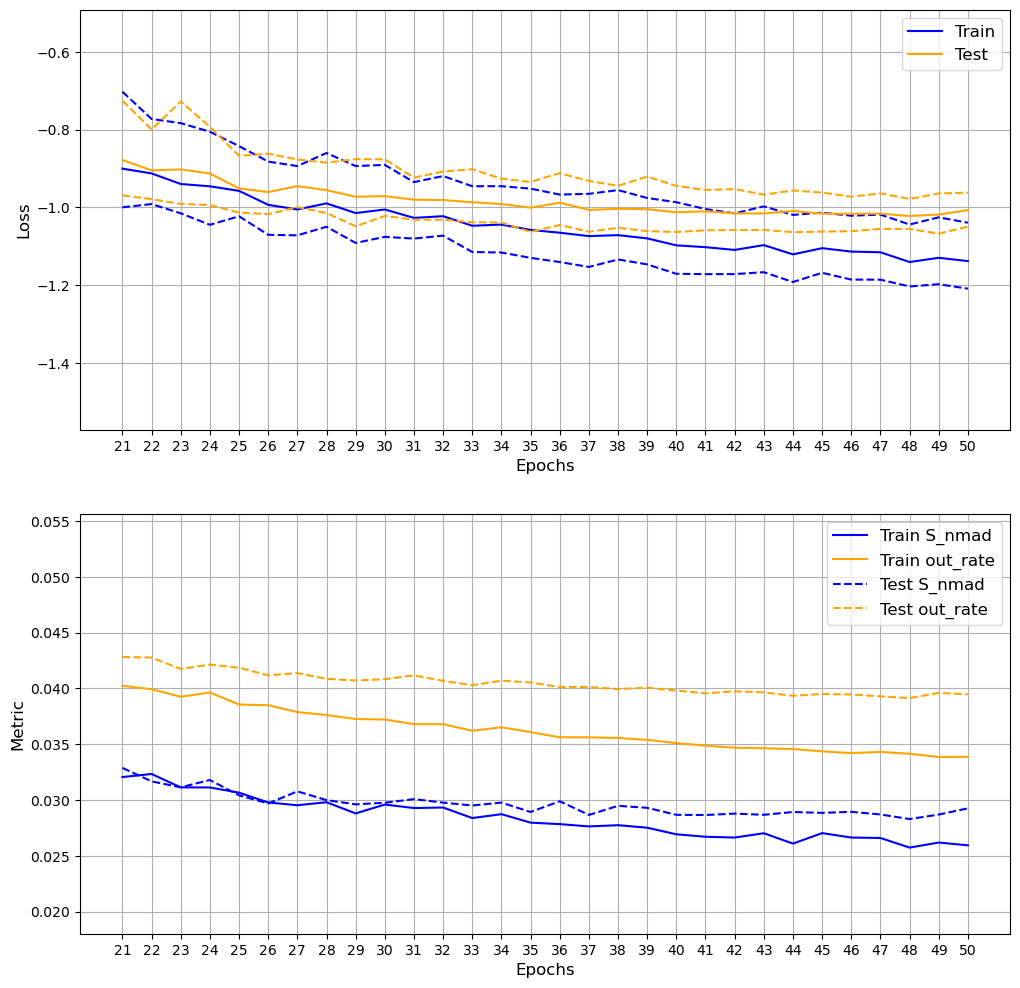

KeyboardInterrupt: 

In [16]:
ens.fit(
    X_train=X_01, 
    y_train=y_01,
    X_test=X_02,
    y_test=y_02,
    epochs=70, 
    batch_size=2**13,
    shuffle=True,
    optimizer=optimizer, 
    optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
    scheduler=scheduler,
    scheduler_args={'gamma': 0.96},
    verbose=True,
    metrics={'S_nmad': sigma_nmad, 'out_rate': out_rate}
);

In [ ]:
print(f'Benchmark S_nmad:\t{round(sigma_nmad(train_20_35_02["Z"], train_20_35_02["max35_z"]), 5)}')
print(f'Benchmark out_rate:\t{round(out_rate(train_20_35_02["Z"], train_20_35_02["max35_z"]), 5)}')

In [ ]:
# ens = DeepEnsemble_GMM.load_pickle('ens_6x400_3g_01.pkl')
epoch_pi, epoch_mu, epoch_sigma, mode, sigma = ens.predict(X_02)
print(sigma_nmad(y_02, mode))
print(out_rate(y_02, mode))

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(train_20_35_02["Z"], mode, alpha=0.5, s=3, label='NN')
plt.scatter(train_20_35_02["Z"], train_20_35_02["max35_z"], alpha=0.5, s=3, label='RF')
plt.legend()
plt.xlabel('spec_z')
plt.ylabel('photo_z')
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 10))
plt.grid()

plt.scatter(np.abs(train_20_35_02["Z"] - mode), 1/sigma, alpha=0.5, s=3, label='NN')
plt.scatter(np.abs(train_20_35_02["Z"] - train_20_35_02["max35_z"]), train_20_35_02['conf35_z'], alpha=0.3, s=3, label='RF')
plt.legend()
plt.xlabel('diff')
plt.ylabel('conf')
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.grid()

plt.hist(train_20_35_02["Z"] - mode, bins=100, alpha=0.5, label='NN')
plt.hist(train_20_35_02["Z"] - train_20_35_02["max35_z"], bins=100, alpha=0.5, label='RF')
plt.xlabel('zspec-zphoto')
plt.legend()
pass;

In [ ]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(12, 6))
plt.ylim(0, 500)
plt.grid()

plt.hist(train_20_35_02["Z"] - mode, bins=100, alpha=0.5, label='NN')
plt.hist(train_20_35_02["Z"] - train_20_35_02["max35_z"], bins=100, alpha=0.5, label='RF')
plt.xlabel('zspec-zphoto')
plt.legend()
pass;

In [ ]:
# пробрасывание связей
# энтропию в лосс и коэффициенты
# анализ параметров распределений
# сравнить распределения с лесом
# убрать галактики из данных
# увеличивать параметры пока не переобучается
# на кривую метрик результат леса

In [ ]:
# ens = DeepEnsemble_GMM(
#     MLP_GMM, 
#     {'sizes': [X_01.shape[1], 400, 400, 400, 400, 400, 400, 2], 'p': 0.0},
#     5, device
# )
# optimizer = torch.optim.Adam
# scheduler = torch.optim.lr_scheduler.ExponentialLR

In [ ]:
# ens.fit(
#     X_train=X_01, 
#     y_train=y_01,
#     X_test=X_02,
#     y_test=y_02,
#     epochs=100, 
#     batch_size=2**13,
#     shuffle=True,
#     optimizer=optimizer, 
#     optimizer_args={'lr': 0.001, 'weight_decay': 0.001},
#     scheduler=scheduler,
#     scheduler_args={'gamma': 0.96},
#     verbose=True,
#     metrics={'S_nmad': sigma_nmad, 'out_rate': out_rate}
# );

In [ ]:
# dfs = []

# feas = pd.read_pickle(
#     f'{data_dir}/20_2-fold-cv/cv2_0/part-00000.features.gz_pkl',
#     compression='gzip'
# )[['ra', 'dec', 'zspec'] + features_list]
# preds = pd.read_pickle(
#     f'{data_dir}/20_2-fold-cv/cv2_0/part-00000.predictions.x1cv2_0.gz_pkl',
#     compression='gzip'
# )[[
#     'zoo_x1cv2_019_z_max', 'zoo_x1cv2_019_z_maxConf',
#     'zoo_x1cv2_021_z_max', 'zoo_x1cv2_021_z_maxConf',
#     'zoo_x1cv2_022_z_max', 'zoo_x1cv2_022_z_maxConf',
#     'zoo_x1cv2_035_z_max', 'zoo_x1cv2_035_z_maxConf'
# ]]
# df = feas.merge(preds, how='right', left_index=True, right_index=True)
# df.columns = ['RA', 'DEC', 'Z'] + features_list + models_cols
# df['fold'] = [0] * df.shape[0]
# dfs.append(df)

# feas = pd.read_pickle(
#     f'{data_dir}/20_2-fold-cv/cv2_1/part-00000.features.gz_pkl',
#     compression='gzip'
# )[['ra', 'dec', 'zspec'] + features_list]
# preds = pd.read_pickle(
#     f'{data_dir}/20_2-fold-cv/cv2_1/part-00000.predictions.x1cv2_1.gz_pkl',
#     compression='gzip'
# )[[
#     'zoo_x1cv2_119_z_max', 'zoo_x1cv2_119_z_maxConf',
#     'zoo_x1cv2_121_z_max', 'zoo_x1cv2_121_z_maxConf',
#     'zoo_x1cv2_122_z_max', 'zoo_x1cv2_122_z_maxConf',
#     'zoo_x1cv2_135_z_max', 'zoo_x1cv2_135_z_maxConf'
# ]]
# df = feas.merge(preds, how='right', left_index=True, right_index=True)
# df.columns = ['RA', 'DEC', 'Z'] + features_list + models_cols
# df['fold'] = [1] * df.shape[0]
# dfs.append(df)

# train_20 = pd.concat(dfs, axis=0)
# train_20.drop_duplicates(subset=['RA', 'DEC'], inplace=True, keep='last')
# train_20.sort_values(by=['RA'], inplace=True)
# train_20.reset_index(drop=True, inplace=True)
# train_20.replace(np.nan, None, inplace=True)
# train_20

In [ ]:
# train_20.to_csv(f'{data_dir}/q_photo_z_train_20.csv', index=False)

In [ ]:
# class MLP(nn.Module):
#     def __init__(self, sizes, p):
#         super().__init__()
#         self.sizes = sizes
#         layers = []
#         for i in range(1, len(sizes)):
#             if i > 1:
#                 layers.append(nn.ReLU())
#                 layers.append(nn.Dropout(p))
#             layers.append(nn.Linear(self.sizes[i-1], self.sizes[i], bias=False))
#             if i < len(sizes) - 1:
#                 layers.append(nn.BatchNorm1d(self.sizes[i]))
#         self.layers = nn.Sequential(*layers)
#         self.layers.apply(self.init_weights)
        
#     def init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                          
#     def forward(self, x, train_m):
#         self.train(train_m)
#         out = self.layers(x)
#         mean, var = out[:, 0], out[:, 1]
#         return mean, var
    
#     def run_epoch(self, dataloader, optimizer=None, loss_f=None):
#         train_m = (optimizer is not None) and (loss_f is not None)
#         true, mean, var = [], [], []
#         for X, y in dataloader:
#             if train_m:
#                 optimizer.zero_grad()
#             batch_mean, batch_var = self(X, train_m)
#             # batch_out = self(X)
#             # batch_mean, batch_var = batch_out[:, 0], batch_out[:, 1]
#             if train_m:
#                 loss = loss_f(y, batch_mean, batch_var)
#                 loss.backward()
#                 optimizer.step()
#             true.append(y.cpu().detach().numpy().reshape(-1))
#             mean.append(batch_mean.cpu().detach().numpy().reshape(-1))
#             var.append(batch_var.cpu().detach().numpy().reshape(-1))
#         true = np.concatenate(true)
#         mean = np.concatenate(mean)
#         var = np.concatenate(var)
#         return true, mean, var
                          
# #     def fit(self, train_dataloader, test_dataloader, epochs, optimizer, loss_f, metrics=[]):
# #         for epoch in range(epochs):
# #             print(f'Epoch #{epoch+1}/{epochs}')
# #             start = time.time()
# #             train_loss, test_loss = 0, 0
# #             batch_num = 0
# #             preds = []
# #             true = []
# #             for X, y in train_dataloader:
# #                 batch_num += 1
# #                 optimizer.zero_grad()
# #                 outputs = self(X)
# #                 mean, var = outputs[:, 0], outputs[:, 1]
# #                 loss = loss_f(y, mean, var)
# #                 train_loss += loss.item()
# #                 loss.backward()
# #                 optimizer.step()
# #                 preds.append(mean.cpu().detach().numpy().reshape(-1))
# #                 true.append(y.cpu().detach().numpy().reshape(-1))
# #             train_loss /= batch_num
# #             print(f'Train loss: {round(train_loss, 5)}\t', end='')
            
# #             preds = np.concatenate(preds)
# #             true = np.concatenate(true)
# #             for metric in metrics:
# #                 print(f'Train {metric}: {round(metrics[metric](true, preds), 5)}\t', end='')
# #             print()
                
# #             batch_num = 0
# #             preds = []
# #             true = []
# #             for X, y in test_dataloader:
# #                 batch_num += 1
# #                 outputs = self(X)
# #                 mean, var = outputs[:, 0], outputs[:, 1]
# #                 loss = loss_f(y, mean, var)
# #                 test_loss += loss.item()
# #                 preds.append(mean.cpu().detach().numpy().reshape(-1))
# #                 true.append(y.cpu().detach().numpy().reshape(-1))
# #             test_loss /= batch_num
# #             print(f'Test  loss: {round(test_loss, 5)}\t', end='')
            
# #             preds = np.concatenate(preds)
# #             true = np.concatenate(true)
# #             for metric in metrics:
# #                 print(f'Test  {metric}: {round(metrics[metric](true, preds), 5)}\t', end='')
# #             print()
# #             print(f'Time: {round(time.time() - start, 5)}')
# #             print('=' * 30)
    
#     @classmethod
#     def get_dataloader(cls, X, y, batch_size=2**13, shuffle=True):
#         order = np.arange(X.shape[0], dtype=int)
#         if shuffle:
#             np.random.shuffle(order)
#         dataset = SimpleDataset(X, y)
#         dataloader = DataLoader(dataset, batch_size, shuffle=False)
#         return dataloader

In [ ]:
# class DeepEnsemble:
#     def __init__(self, BaseModel, base_model_args, M, device=torch.device('cpu')):
#         self.BaseModel = BaseModel
#         self.base_model_args = base_model_args
#         self.M = M
#         self.device = device
#         self.models = []
#         for i in range(M):
#             self.models.append(self.BaseModel(**self.base_model_args).to(self.device))
        
#     def loss(self, y, mean, var):
#         if isinstance(y, torch.Tensor):
#             return ((var + torch.exp(-var) * (mean - y)**2) / 2).mean()
#         else:
#             return ((var + np.exp(-var) * (mean - y)**2) / 2).mean()
                
#     def fit(
#         self, X_train, y_train, X_test=None, y_test=None, 
#         epochs=5, batch_size=2**13, shuffle=True, 
#         optimizer=torch.optim.Adam, optimizer_args={'lr': 0.0005, 'weight_decay': 0.0001}, 
#         verbose=True, metrics=[]
#     ):
#         print(f'Device: {self.device}')
#         X_train_tensor = torch.tensor(X_train, device=torch.device(device), dtype=torch.float)
#         y_train_tensor = torch.tensor(y_train, device=torch.device(device), dtype=torch.float)
#         X_test_tensor = torch.tensor(X_test, device=torch.device(device), dtype=torch.float)
#         y_test_tensor = torch.tensor(y_test, device=torch.device(device), dtype=torch.float)
        
#         test_dataloader = self.BaseModel.get_dataloader(
#             X_test_tensor, y_test_tensor,
#             batch_size=batch_size, shuffle=shuffle
#         )
        
#         test_m = (X_test is not None) and (y_test is not None)
#         print(f'Test mode: {test_m}')
#         print('=' * 40)
        
#         optimizers = []
#         for model in self.models:
#             optimizers.append(optimizer(model.parameters(), **optimizer_args))

#         train_metric_vals = {metric: [] for metric in metrics}
#         train_losses = []
#         if test_m:
#             test_metric_vals = {metric: [] for metric in metrics}
#             test_losses = []
#         else:
#             test_metric_vals = None
#             test_losses = None
    
#         for epoch in range(epochs):
#             print(f'EPOCH #{epoch+1}/{epochs}:')
#             print('-' * 40)
#             start = time.time()
            
#             #TRAIN
            
#             train_dataloader = self.BaseModel.get_dataloader(
#                 X_train_tensor, y_train_tensor,
#                 batch_size=batch_size, shuffle=shuffle
#             )
            
#             epoch_mean, epoch_var = [], []
#             epoch_losses = []
#             for i, model in enumerate(self.models):
#                 epoch_true, m, v = model.run_epoch(train_dataloader, optimizers[i], self.loss)
#                 epoch_mean.append(m)
#                 epoch_var.append(v)
#                 epoch_losses.append(self.loss(epoch_true, m, v).item())
#             t_m = np.array(epoch_mean)
#             epoch_mean = np.mean(t_m, axis=0)
#             t_v = np.array(epoch_var)
#             epoch_var = np.mean(t_v, axis=0) + np.mean(t_m - epoch_mean, axis=0)
            
#             train_losses.append(epoch_losses)
#             if verbose:
#                 print(f'Trian losses: {[round(l, 5) for l in epoch_losses]}')
#                 print(f'AVG train loss: {round(np.mean(epoch_losses), 5)}')
            
#             for metric in metrics:
#                 train_metric_vals[metric].append(metrics[metric](epoch_true, epoch_mean))    
#             if verbose:
#                 for metric in metrics:
#                       print(f'Train {metric}: {round(train_metric_vals[metric][-1], 5)}\t', end='')
#                 print()
#             print('-' * 40)
                
#             #TEST
#             if test_m:     
#                 epoch_mean, epoch_var = [], []
#                 epoch_losses = []
#                 for i, model in enumerate(self.models):
#                     epoch_true, m, v = model.run_epoch(test_dataloader)
#                     epoch_mean.append(m)
#                     epoch_var.append(v)
#                     epoch_losses.append(self.loss(epoch_true, m, v).item())
#                 t_m = np.array(epoch_mean)
#                 epoch_mean = np.mean(t_m, axis=0)
#                 t_v = np.array(epoch_var)
#                 epoch_var = np.mean(t_v, axis=0) + np.mean(t_m - epoch_mean, axis=0)

#                 test_losses.append(epoch_losses)
#                 if verbose:
#                     print(f'Test losses: {[round(l, 5) for l in epoch_losses]}')
#                     print(f'AVG test loss: {round(np.mean(epoch_losses), 5)}')

#                 for metric in metrics:
#                     test_metric_vals[metric].append(metrics[metric](epoch_true, epoch_mean))    
#                 if verbose:
#                     for metric in metrics:
#                           print(f'Test {metric}: {round(test_metric_vals[metric][-1], 5)}\t', end='')
#                     print()
#                 print('-' * 40)
            
#             print(f'Time: {round(time.time() - start, 3)}')
#             print('=' * 40)
#         return train_metric_vals, train_losses, test_metric_vals, test_losses